#  次世代型CMB観測実験のための全天スキャンシミュレータ
## 髙瀬 祐介 (岡山大学)
### *Julia in Physics 2021 Sep. 3*

# Falcons.jl

[Falcons](https://yusuke-takase.github.io/Falcons.jl/dev/)は宇宙マイクロ波背景放射(Cosmic Microwave Background, CMB)など衛星による全天観測が求められる実験のためのシミュレーションツールである．

一般に，観測衛星は望遠鏡を空のある一点へ向け，その点からの放射を観測する．この時，望遠鏡が向いている方向を特徴づける量としてPointingという量が用いられ，次の形で定義される．
$$
\boldsymbol{p(t)} = ( \theta(t), \phi(t), \psi(t) )
$$
`Falcons`はこのPointing計算を高速に提供する．

<img src="./img/example.gif">

## HEALPix
<img src="./img/healpixGridRefinement.jpg">


[HEALPix](https://healpix.jpl.nasa.gov/)は球面上のデータをピクセルという領域に区切って扱うためのフレームワークで，C++やPython ([healpy](https://healpy.readthedocs.io/en/latest/))などの様々な言語でサポートされている．
`Falcons.jl`は[Healpix.jl](https://github.com/ziotom78/Healpix.jl)に依存している．ここでは簡単に`Healpix.jl`を用いて`HEALPix`のピクセルという概念を確認する．

In [1]:
using Healpix
using Plots
using PyPlot
pyplot()

Plots.PyPlotBackend()

HEALPixは$Nside$というパラメータを指定することで空を$Npix$個のピクセルに分割する．$Nside$と$Npix$の関係は次のようになる．  
$$
Npix = 12Nside^2
$$
ここで$Nside$は$2$の累乗である必要がある．  
次に`HEALPix`のスカイマップの仕組みについて確認する．マップは$Npix$個の要素を持つ配列から作られ，北極から南極にかけて螺旋状にインデックスが与えられる`Ring Order`がよく用いられる．
ピクセルのインデックスは以下の図で確認できる．  

<img src="./img/pixel_grid.png">  

[The HEALPix Primer](https://healpix.jpl.nasa.gov/pdf/intro.pdf)より引用．

上の図を実際に再現してみると次のようになる．

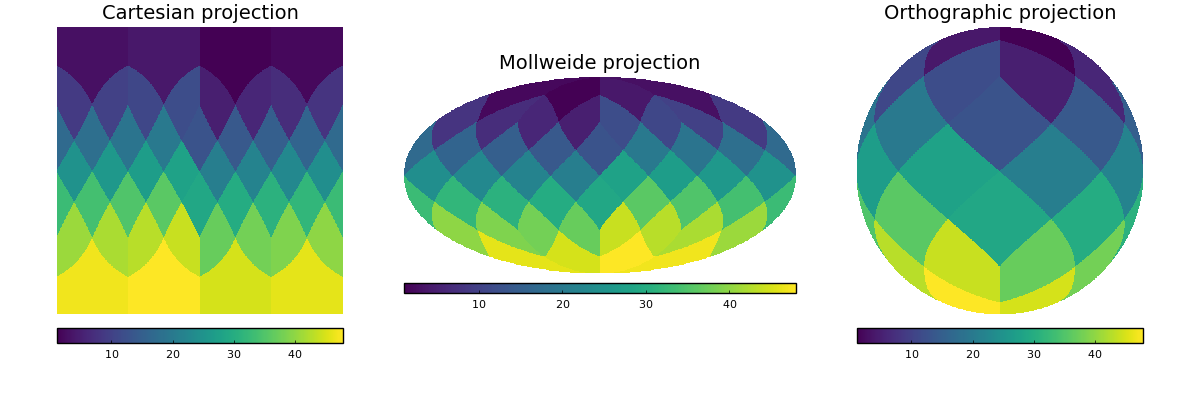

In [2]:
nside = 2
m = HealpixMap{Float64, RingOrder}(nside)
m.pixels = 1:length(m)

cartview = Plots.plot(m, equirectangular, c=:viridis, title="Cartesian projection")
mollview = Plots.plot(m, mollweide, c=:viridis, title="Mollweide projection")
orthoview = Plots.plot(m, orthographic, c=:viridis, title="Orthographic projection")

Plots.plot(cartview, mollview, orthoview , layout=(1,3), size=(1200,400))

`Healpix.jl`は`HealpixMap`という構造体をPlotsへ渡すことで，球面を様々形状の2Dマップへ投影する機能も提供している．

# 衛星スキャン戦略
全天観測衛星は宇宙全天を隈なく探索するためのスキャン戦略を設定する．スキャン戦略の代表的なパラメータは以下の4つで，
$$
\alpha: 歳差軸角度\\
\beta: スピン軸角度\\
\omega_\alpha: 歳差運動角速度\\
\omega_\beta: スピン運動角速度\\
$$
歳差運動とスピンによる回転で衛星の観測方向を回転させながらスキャンを行う．この時，太陽-地球系のL2点に設置される衛星では公転運動も利用する場合が多い．
<img src="./img/scan_strategy.png">

# Falconsのデモンストレーション
ここから`Falcons`のデモンストレーションを行う．初めにスキャン戦略を設定する．

In [3]:
using Falcons

ss = gen_ScanningStrategy();
ss.nside = 64
ss.alpha = 40
ss.beta = 55
ss.spin_rpm = 0.03
ss.prec_rpm = period2rpm(160) # period2rpm( min. )
ss.sampling_rate = 1;

`ss`は`ScanningStrategy`という構造体になっており，上記のようにアクセスできる．

設定したスキャン戦略で空がどのようにスキャンされるかプロットして確認する．  
Pointingの時系列データ(Time-Orderd Data, TOD)を取得するには`get_pointings`関数を使用する．この際，引数は`ss`と観測期間のみで良い．

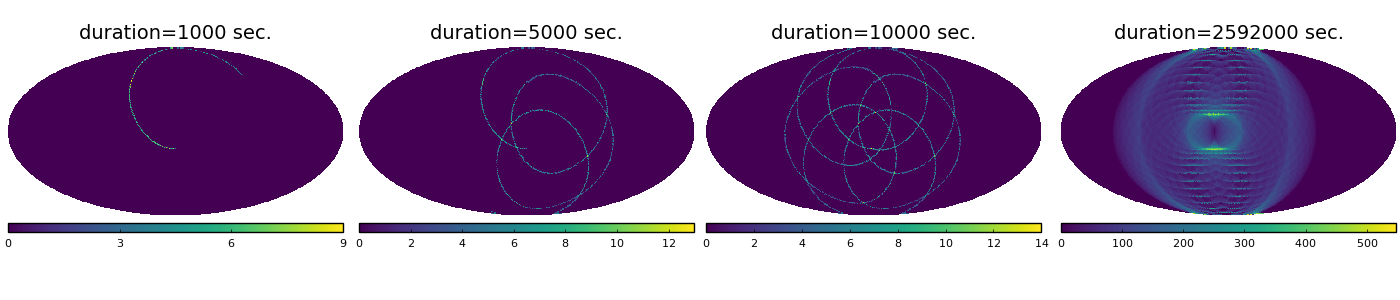

In [4]:
day = 60*60*24
time = [1000, 5000, 10000, 30day]
track = [HealpixMap{Float64, RingOrder}(ss.nside) for i in eachindex(time)]

for i in eachindex(time)
    # pointingの計算
    pointings = get_pointings(ss, 0, time[i]) # 観測期間を0秒からtime[i]までとして設定
    # TOD --> Mapへ格納
    track[i].pixels = angtod2hitmap(ss.nside, pointings["theta"], pointings["phi"])
end

plts = [Plots.plot(track[i], c=:viridis, title="duration="*"$(time[i]) sec.") for i in eachindex(time)]
    
Plots.plot(plts[1], plts[2], plts[3], plts[4], layout=(1,length(time)), size=(1400,300))

`get_pointings`関数の返り値は辞書型の配列になっており，それぞれ
```julia
pointings = get_pointings(ss::ScanningStrategy, start::Int, stop::Int)

pointings["theta"] # Array
pointings["phi"]   # Array
pointings["psi"]   # Array
```
という構造を持つ．これらの配列要素にはTODが格納されている．  
また，Hitmapを作成するためには`angtod2hitmap`関数を使用すれば良い．引数はNsideと$\theta, \phi$のTODである．

上の使用例は原理的なもので，実際にPointing計算からHitmapの作成は`ScanningStrategy2map`関数で容易に行うことができる．

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


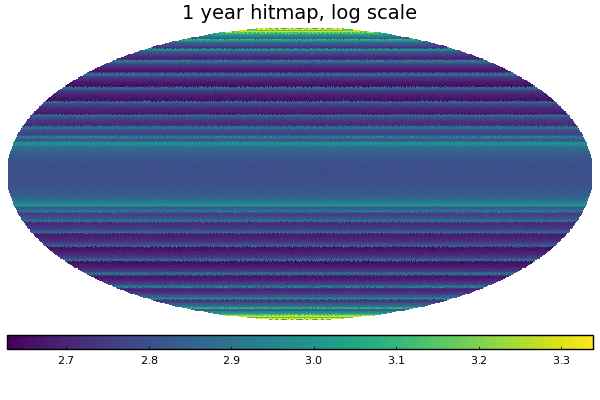

In [5]:
outmap = ScanningStrategy2map(ss, 4)

hitmap = HealpixMap{Float64, RingOrder}(ss.nside)
hitmap.pixels = log10.(outmap[1])
Plots.plot(hitmap, c=:viridis, title="1 year hitmap, log scale")

# Crosslink
ここでCrosslinkという新たな概念を導入する．近年，CMBの偏光を精密測定することでインフレーション起源の原始重力波を探索する研究が世界中で行われている．
一般に，偏光を観測するためには検出器の角度$\psi$を変えながら$\mu$回観測する必要がある．つまり，全天に分布するピクセルから放射される電磁波の偏光を衛星で測定するためには，衛星はそのピクセルをあらゆる方向からスキャンしなければならない．

<img src="./img/crosslink.png">

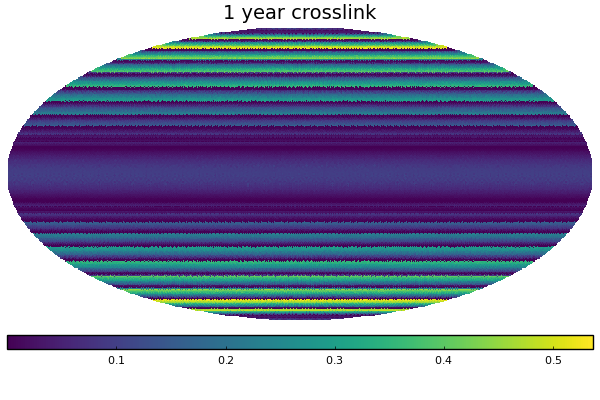

In [7]:
xlink2 = HealpixMap{Float64, RingOrder}(ss.nside)
xlink2.pixels = outmap[3]
Plots.plot(xlink2, c=:viridis, title="1 year crosslink")

色が黄色い領域ほど，同じ方向しかスキャンができておらず，偏光観測における不定性が大きくなってしまう．

## 今回のスキャン結果
1. マップの$\phi$方向(東西方向)に線が走っている --> これはバイアスを生む可能性がある．
2. Crosslinkが大きい --> 偏光観測に対する不定性が大きい．

マップの分布をヒストグラムで確認してみる．ヒストグラムの分散が小さい方がスキャンが均一であると言える．

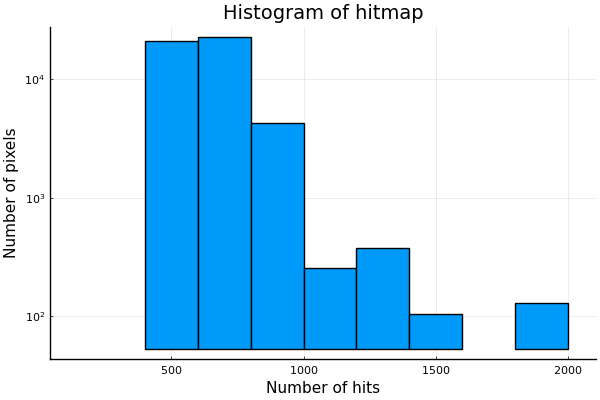

In [9]:
histogram(outmap[1], bins=range(0, maximum(outmap[1]), step=200), 
    title="Histogram of hitmap",
    xlabel="Number of hits",
    ylabel="Number of pixels",
    alpha=1,
    label=false,
    yaxis=:log10)

ヒストグラムが分裂しているため，ヒットに偏りがあることがわかる．またヒストグラム幅も500 - 2000 ヒットにわたって分布している．  
クロスリンク(n=2)についても確認してみる．

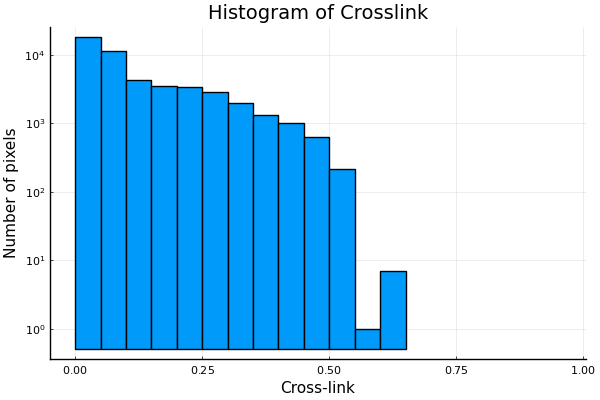

In [10]:
histogram(outmap[3], bins=range(0, 1, step=0.05), 
    title="Histogram of Crosslink",
    xlabel="Cross-link",
    ylabel="Number of pixels",
    alpha=1,
    label=false,
    yaxis =:log10)

クロスリンクも分散が大きく，平均値も大きいことがわかる．やはりこのスキャン戦略はあまり偏光観測には適していないということになる．

# スキャン戦略の再構築
では偏光観測に適しているスキャン戦略はどのようになるだろうか？
例えば，衛星の角速度について[Duc Thuong Hoang et al.](https://arxiv.org/abs/1706.09486)によると
$\theta=\frac{\omega_{spin}}{\omega_{prec}}$，$a_n$を整数と定義した時，

<img src="./img/ratio.png">

のような表式で展開できる$\theta$の場合，軌道がだんだんずれていき，同じ緯度上で重なりにくくなるようである．  
この論文に倣って，スピンと歳差運動の角速度比が割り切れない数値でスキャン戦略の再構成を行う．

In [ ]:
println("スピンの角速度: ", ss.spin_rpm)
println("歳差運動の角速度: ", ss.prec_rpm)
println("現在の角速度比: ", ss.spin_rpm/ss.prec_rpm)

既約分数で表せる角速度比となっていた．歳差運動の角速度に少し変更を加える．

In [ ]:
ss.prec_rpm = 0.00653973
println("変更後の角速度比: ", ss.spin_rpm/ss.prec_rpm)

In [ ]:
outmap = ScanningStrategy2map(ss, 4);

hitmap = HealpixMap{Float64, RingOrder}(ss.nside)
X_2 = HealpixMap{Float64, RingOrder}(ss.nside)
hitmap.pixels = log10.(outmap[1])
X_2.pixels = outmap[3];

In [ ]:
hit = Plots.plot(hitmap, c=:viridis, title="1 year hitmap, log scale")
xlink = Plots.plot(X_2, c=:viridis, title="1 year crosslink(n=2)");
Plots.plot(hit, xlink, layout=(1,2), size=(1200,300))

$\phi$方向の線が消え，スピンによる接線のみになったことがわかる．次にヒストグラムを確認してみる．

In [ ]:
hit_hist = histogram(outmap[1], bins=range(0, maximum(outmap[1]), step=200), 
    title="Histgram of hitmap",
    xlabel="Number of hits",
    ylabel="Number of pixels",
    alpha=1,
    label=false,
    yaxis=:log10)

xlink_hist = histogram(outmap[3], bins=range(0, 1, step=0.05), 
    title="Histgram of Cross-link(n=2)",
    xlabel="Crosslink",
    ylabel="Number of pixels",
    alpha=1,
    label=false,
    yaxis =:log10)

Plots.plot(hit_hist, xlink_hist, layout=(1,2), size=(1200,300))

### 結果
1. Hitmapのヒストグラムに分裂が消えヒット数の分布がなだらかになっている．
2. クロスリンクの平均値が小さくなり，分散も小さくなっている．

この結果から，初めのパラメータセットよりは偏光観測に対するスキャン戦略由来の系統的効果の低減が期待される．

最後に次世代の観測実験を想定して検出器アレイによるシミュレーションを同様に行ってみる．

# 検出器アレイによるシミュレーション
まず，複数の検出器が放射状に配置された検出器アレイを構成する．

In [ ]:
fake_focalplane_theta = []
fake_focalplane_phi = []
k = 1
for i in 5:8:30
    for j in 0:45:360-45
        push!(fake_focalplane_theta, i)
        push!(fake_focalplane_phi, j)
        k += 1
    end
end

In [ ]:
println("Total number of detectors: ", length(fake_focalplane_theta))
ss.FP_theta = fake_focalplane_theta # Boresightを中心とした(theta*cos(phi), theta*sin(phi))となる座標系
ss.FP_phi = fake_focalplane_phi
ss.duration = 1
outmap = ScanningStrategy2map(ss, 1);

focalplane = HealpixMap{Float64, RingOrder}(ss.nside)
focalplane.pixels = outmap[1]
Plots.plot(focalplane, c=:viridis, title="Projected fake focal plane into the sky", size=(1000,600))

観測開始から1秒後のヒットマップをプロットした．空に直径60deg.の視野が展開されていることがわかる．
各種マップの計算の手続きは単一検出器の時と同じであり，次の通りである．

In [ ]:
ss.duration = 30day
outmap = ScanningStrategy2map(ss, 6);

multi_det = HealpixMap{Float64, RingOrder}(ss.nside)
multi_det.pixels = outmap[1]
Plots.plot(multi_det, c=:viridis, title="1 month observation with detectors array", size=(1000,600))

## まとめ
- `Falcons`では複数の検出器を搭載した衛星のPointingを計算し，スキャン戦略の評価が行える．また，Pointingから時系列データの解析に発展させることも可能である．
- 内部では[StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl)や[ReferenceFrameRotations](https://github.com/JuliaSpace/ReferenceFrameRotations.jl)が提供するQuarternionで線形代数演算が行われており単一スレッドでも高速に動作する．
    - マルチスレッドにも対応している．
- 任意のスーパーコンピュターで動作可能である．